In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import datetime

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
     

2023-04-22 13:11:29.112994: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 13:11:29.172949: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 13:11:29.487800: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 13:11:29.489578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 13:11:30.999416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Reference https://www.tensorflow.org/tutorials/structured_data/feature_columns?hl=zh-cn
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md


In [5]:
data=pd.read_csv('/home/jiayi/5moU/data/DL_fromTombo/avg_tombo.csv')
data

,indx,kmer,avg_mean,avg_std,avg_mdintense,avg_length2,label
0,20,CATCT,-0.379295,0.059457,-0.386073,18.6,1
1,22,TCTTC,-0.224518,0.079366,-0.226347,21.8,1
2,23,CTTCG,-0.027033,0.106017,-0.016552,24.2,1
3,35,CGTGG,0.135500,0.146305,0.127863,19.6,1
4,44,CCTGC,-0.297275,0.098792,-0.307865,59.0,1
...,...,...,...,...,...,...,...
1822819,350,GCTGG,0.251371,0.097341,0.250863,205.6,0
1822820,365,GATCC,-0.242580,0.199999,-0.230983,8.0,0
1822821,374,GATCC,-0.153419,0.253634,-0.074312,570.2,0
1822822,377,CCTGA,-0.008397,0.117552,-0.003787,137.6,0


In [6]:
train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1166607 train examples
291652 validation examples
364565 test examples


In [11]:

def df_to_dataset(data, shuffle=True, batch_size=32):
  data = data.copy()
  labels = data.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((dict(data), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(data))
  ds = ds.batch(batch_size)
  return ds

In [12]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


val, labels = tuple(zip(*val_ds))

AttributeError: 'tuple' object has no attribute 'copy'

In [10]:
#Understand the input pipeline
#Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of kmer:', feature_batch['kmer'])
  print('A batch of targets:', label_batch )

2023-04-22 13:13:04.669793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1166607]
	 [[{{node Placeholder/_4}}]]
2023-04-22 13:13:04.670243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [1166607]
	 [[{{node Placeholder/_5}}]]


Every feature: ['indx', 'kmer', 'avg_mean', 'avg_std', 'avg_mdintense', 'avg_length2']
A batch of kmer: tf.Tensor([b'GGTGC' b'CATCC' b'CATGA' b'TGTTC' b'TCTAC'], shape=(5,), dtype=string)
A batch of targets: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)


In [7]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

2023-04-16 20:03:01.583219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [1166607]
	 [[{{node Placeholder/_2}}]]
2023-04-16 20:03:01.583756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [1166607]
	 [[{{node Placeholder/_3}}]]


In [8]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [9]:
kmer = feature_column.categorical_column_with_vocabulary_list(
      'kmer', data.kmer.unique())
kmer_embedding = feature_column.embedding_column(kmer, dimension=4)
demo(kmer_embedding)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
[[ 0.54814655 -0.87871104 -0.57318443  0.05375203]
 [-0.57837915  0.47989056 -0.87114906 -0.48997074]
 [ 0.23714423 -0.8234276   0.9255891  -0.02406771]
 [-0.25595716 -0.28127643  0.35024804  0.39918992]
 [ 0.23714423 -0.8234276   0.9255891  -0.02406771]]


In [10]:
feature_columns = []
# embedding columns
kmer = feature_column.categorical_column_with_vocabulary_list(
      'kmer', data.kmer.unique())
kmer_embedding = feature_column.embedding_column(kmer, dimension=4)
feature_columns.append(kmer_embedding)

# numeric cols
for header in ['avg_mean','avg_std','avg_mdintense','avg_length2']:
  feature_columns.append(feature_column.numeric_column(header))

demo(feature_columns)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
[[ 1.2060000e+02 -5.1180553e-01 -4.8861057e-01  8.9509062e-02
   6.9001609e-01  2.8046715e-01 -2.0979883e-01  2.0537612e-01]
 [ 1.0520000e+02  2.9227889e-01  2.8562436e-01  2.3213746e-01
  -5.6724167e-01 -5.1040214e-01  8.2638890e-01  3.9299291e-02]
 [ 4.1200001e+01 -1.7317981e-02 -5.0901645e-03  1.6411087e-01
  -2.1072327e-01  2.1584496e-01 -9.5782411e-01 -5.3295702e-01]
 [ 7.8599998e+01  1.2109651e-01  1.0175025e-01  1.6175336e-01
   5.4808694e-01 -1.8543621e-03 -3.5200772e-01  8.7790757e-01]
 [ 2.1600000e+01  1.4567105e-01  1.3296910e-01  1.3738136e-01
  -2.1072327e-01  2.1584496e-01 -9.5782411e-01 -5.3295702e-01]]


In [13]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 100
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

val, labels = tuple(zip(*val_ds))

AttributeError: 'tuple' object has no attribute 'copy'

In [40]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/home/jiayi/5moU/Code/extract_tombo/log/TF_Dense_logs'),
]


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history=model.fit(train_ds,
          validation_data=val_ds,
          epochs=50,
         callbacks= [tensorboard_callback])

Epoch 1/50


2023-04-14 15:07:45.926701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1166607]
	 [[{{node Placeholder/_4}}]]
2023-04-14 15:07:45.927332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [1166607]
	 [[{{node Placeholder/_6}}]]


11665/11667 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8917WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'indx': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=int64>, 'kmer': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'avg_mean': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=float64>, 'avg_std': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=float64>, 'avg_mdintense': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=float64>, 'avg_length2': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=float64>}. Consider rewriting this model with the Functional API.


2023-04-14 15:08:32.427737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [291652]
	 [[{{node Placeholder/_4}}]]


11667/11667 [==============================] - 51s 4ms/step - loss: 0.3141 - accuracy: 0.8917 - val_loss: 0.3010 - val_accuracy: 0.8917
Epoch 2/50
11667/11667 [==============================] - 50s 4ms/step - loss: 0.2991 - accuracy: 0.8918 - val_loss: 0.2972 - val_accuracy: 0.8917
Epoch 3/50
11667/11667 [==============================] - 51s 4ms/step - loss: 0.2948 - accuracy: 0.8919 - val_loss: 0.2931 - val_accuracy: 0.8917
Epoch 4/50
11667/11667 [==============================] - 52s 4ms/step - loss: 0.2916 - accuracy: 0.8920 - val_loss: 0.2898 - val_accuracy: 0.8917
Epoch 5/50
11667/11667 [==============================] - 53s 4ms/step - loss: 0.2891 - accuracy: 0.8921 - val_loss: 0.2869 - val_accuracy: 0.8919
Epoch 6/50
11667/11667 [==============================] - 52s 4ms/step - loss: 0.2868 - accuracy: 0.8924 - val_loss: 0.2866 - val_accuracy: 0.8920
Epoch 7/50
11667/11667 [==============================] - 52s 4ms/step - loss: 0.2851 - accuracy: 0.8925 - val_loss: 0.2839 - val

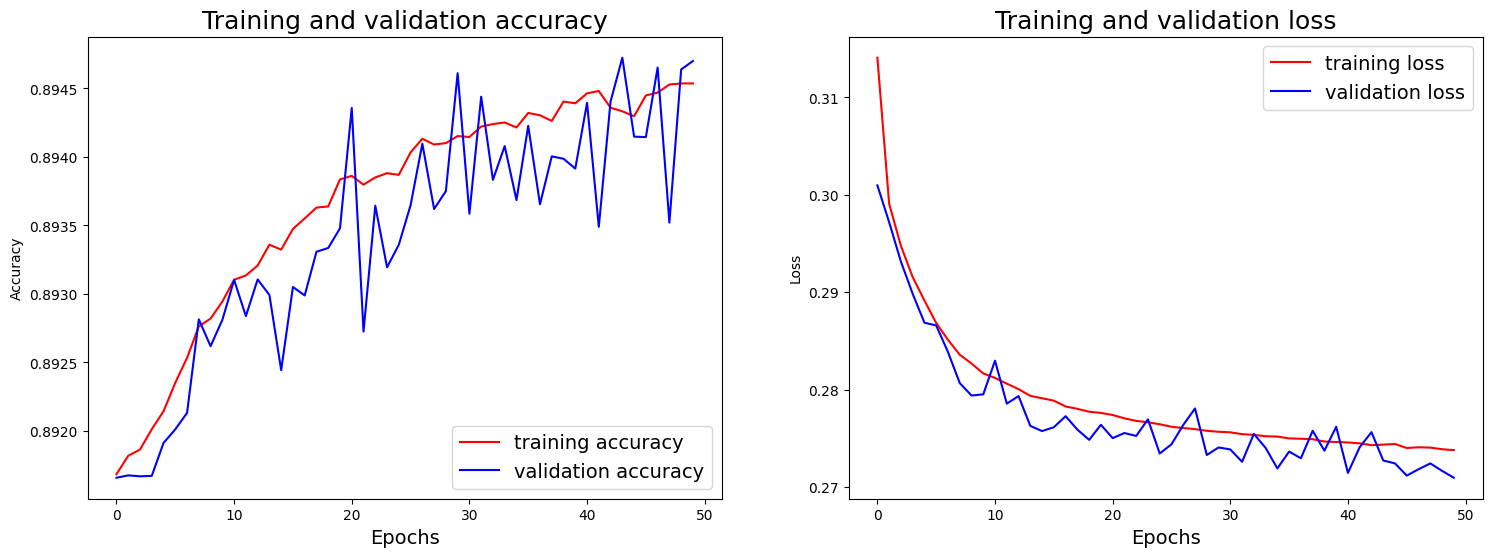

In [41]:
from matplotlib import pyplot as plt
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

fig = plt.figure(figsize=(18,6))

plt.subplot2grid((1,2),(0,0),colspan=1,rowspan=1)
plt.plot(epochs, acc, 'r', label='training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Training and validation accuracy', size=18)
plt.xlabel('Epochs', size=14)
plt.ylabel('Accuracy')
plt.legend(prop={'size': 14})

plt.subplot2grid((1,2),(0,1),colspan=1,rowspan=1)
plt.plot(epochs, loss, 'r', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss', size=18)
plt.xlabel('Epochs', size=14)
plt.ylabel('Loss')
plt.legend(prop={'size': 14})

plt.show()


fig.savefig('/home/jiayi/5moU/Results/avg_sig_trainlog.png')

In [44]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_curve,roc_auc_score
cm = confusion_matrix(train_ds, model.fit(val_ds))

fig = plt.figure(figsize = (8,8))

ax1 = sns.heatmap(cm,annot=True,fmt='.20g',xticklabels = ['unmoified','modified'] , yticklabels = ['unmodified','modified'])
ax1.set_title('Confusion matrix for neural network model',size = 18)
ax1.set_xlabel('predict')
ax1.set_ylabel('true')

plt.show()

fig.savefig('/home/jiayi/5moU/Results/confusion.png')

2917/2917 [==============================] - 8s 3ms/step - loss: 0.2741 - accuracy: 0.8943


TypeError: Expected sequence or array-like, got <class 'keras.callbacks.History'>

In [64]:
import os
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [85]:
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    feature_columns,
    labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

NameError: name 'labels' is not defined

In [77]:
reload_ext tensorboard


In [82]:
%tensorboard --logdir="/home/jiayi/5moU/Code/extract_tombo/logs/fit"
#tensorboard --logdir logs/fit
#10.7.6.98:6006
#http://hostname:port
#tensorboard --logdir="./tb_log"
#tensorboard --logdir= "/home/jiayi/5moU/Code/extract_tombo/logs/fit"

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-04-09 20:17:26.168761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-09 20:17:27.898136: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/jiayi/miniconda3/lib/python3.9/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /home/jiayi/miniconda3/lib/python3.9/site-packages/tensorboard_data_server/bin/server)
/home/jiayi/miniconda3/lib/python3.9/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (requir

In [59]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

  111/11393 [..............................] - ETA: 15s - loss: 0.2859 - accuracy: 0.8970

2023-04-09 13:05:26.150445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [364565]
	 [[{{node Placeholder/_6}}]]


11393/11393 [==============================] - 15s 1ms/step - loss: 0.2875 - accuracy: 0.8925
Accuracy 0.8924581408500671


In [ ]:
model.summary()

In [43]:
load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [61]:
!kill 2964666

In [44]:

tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2964666), started 0:04:06 ago. (Use '!kill 2964666' to kill it.)